In [1]:
import xlwings as xw
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\nelau\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\nelau\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# open workbook, read the sheet
wb = xw.Book("Effect of Gestures on Intelligibility under Auditory Noise - similarity scores.xlsx")
sheet = wb.sheets["values"]
data = sheet.range("A1").options(pd.DataFrame, expand='table', header=False, index=False).value
df = pd.DataFrame(data)
wb.close()

In [3]:
# condition combinations of noise (low, moderate, high) and gestures (low, moderate, high)
conditions = [('low', 'low'), ('moderate', 'low'), ('high', 'low'),
              ('low', 'moderate'), ('moderate', 'moderate'), ('high', 'moderate'),
              ('low', 'high'), ('moderate', 'high'), ('high', 'high')] * 2

# empty lists to store data
noise_levels = []
gesture_levels = []
similarity_scores = []
participant_ids = []

# iterating through each row (participant) and column (video)
for participant, row in df.iterrows():
    for trial, score in enumerate(row):
        noise_levels.append(conditions[trial][0])
        gesture_levels.append(conditions[trial][1])
        similarity_scores.append(score)
        participant_ids.append(participant + 1)

# new dataframe
new_df = pd.DataFrame({
    'Participant': participant_ids,
    'Noise_level': noise_levels,
    'Gesture_level': gesture_levels,
    'Similarity_score': similarity_scores
})

# printing a few rows to check!
print(new_df.head(20))

    Participant Noise_level Gesture_level  Similarity_score
0             1         low           low          0.883532
1             1    moderate           low          0.570523
2             1        high           low          0.766672
3             1         low      moderate          0.930381
4             1    moderate      moderate          0.864380
5             1        high      moderate          0.566943
6             1         low          high          0.885948
7             1    moderate          high          0.692741
8             1        high          high          0.730855
9             1         low           low          0.872905
10            1    moderate           low          0.750947
11            1        high           low          0.525707
12            1         low      moderate          0.981844
13            1    moderate      moderate          0.860911
14            1        high      moderate          0.384064
15            1         low          hig

In [4]:
# just in case
new_df['Similarity_score'] = pd.to_numeric(new_df['Similarity_score'])

# performing ANOVA
model = ols('Similarity_score ~ C(Noise_level) + C(Gesture_level) + C(Noise_level):C(Gesture_level)', data=new_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                   sum_sq     df          F        PR(>F)
C(Noise_level)                   2.298121    2.0  42.763029  1.980471e-17
C(Gesture_level)                 0.311127    2.0   5.789400  3.344546e-03
C(Noise_level):C(Gesture_level)  0.380456    4.0   3.539726  7.516930e-03
Residual                         9.915184  369.0        NaN           NaN


In [5]:
# performing Tukey's HSD for noise level
tukey_noise = pairwise_tukeyhsd(endog=new_df['Similarity_score'],
                                groups=new_df['Noise_level'],
                                alpha=0.05)

# perform Tukey's HSD for gesture level
tukey_gesture = pairwise_tukeyhsd(endog=new_df['Similarity_score'],
                                  groups=new_df['Gesture_level'],
                                  alpha=0.05)

print("Tukey's HSD for noise level:")
print(tukey_noise)
print("\nTukey's HSD for gesture level:")
print(tukey_gesture)

Tukey's HSD for noise level:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
  high      low   0.1841    0.0  0.1342  0.234   True
  high moderate   0.1361    0.0  0.0862  0.186   True
   low moderate   -0.048 0.0621 -0.0978 0.0019  False
-----------------------------------------------------

Tukey's HSD for gesture level:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
  high      low  -0.0332 0.3229 -0.0875 0.0211  False
  high moderate   0.0371 0.2447 -0.0173 0.0914  False
   low moderate   0.0702 0.0071  0.0159 0.1246   True
-----------------------------------------------------


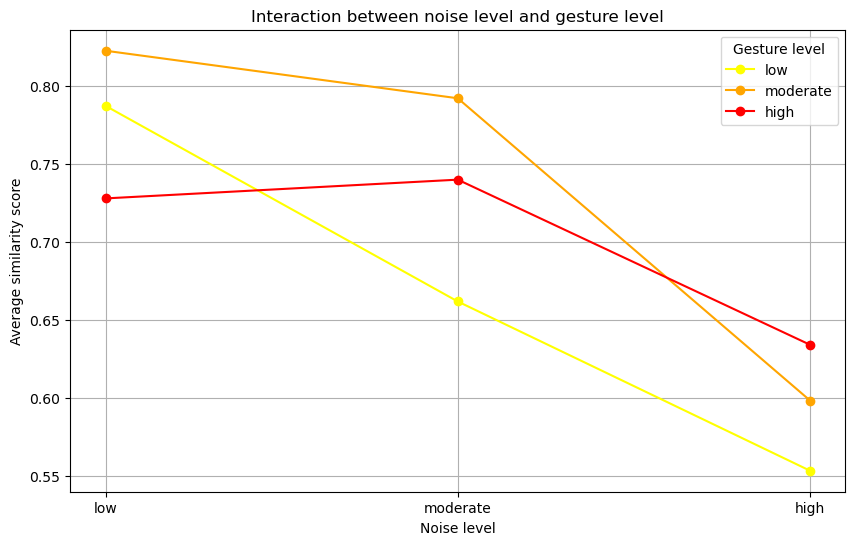

In [6]:
# illustrative plot equivalent to heatmap in the other notebook
# had to define the order of noise levels, otherwise the plot was switched around
noise_order = ['low', 'moderate', 'high']

# consistent color scheme with the other notebook :)
colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(10, 6))

# calculating mean similarity scores 
for index, gesture in enumerate(new_df['Gesture_level'].unique()):
    data = new_df[new_df['Gesture_level'] == gesture]
    mean_scores = [data[data['Noise_level'] == level]['Similarity_score'].mean() for level in noise_order]
    plt.plot(noise_order, mean_scores, marker='o', label=gesture, color=colors[index % len(colors)])

plt.xlabel('Noise level')
plt.ylabel('Average similarity score')
plt.title('Interaction between noise level and gesture level')
plt.legend(title='Gesture level')
plt.grid(True)
plt.show()

In [7]:
# calculating effect sizes
def partial_eta_squared(aov_table):
    return aov_table['sum_sq'][:-1] / (aov_table['sum_sq'][:-1] + aov_table['sum_sq'][-1])

effect_sizes = partial_eta_squared(anova_table)
print("Effect sizes (partial eta squared):")
print(effect_sizes)

Effect sizes (partial eta squared):
C(Noise_level)                     0.188165
C(Gesture_level)                   0.030424
C(Noise_level):C(Gesture_level)    0.036953
Name: sum_sq, dtype: float64


C:\Users\nelau\AppData\Local\Temp\ipykernel_24168\2642552668.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return aov_table['sum_sq'][:-1] / (aov_table['sum_sq'][:-1] + aov_table['sum_sq'][-1])
